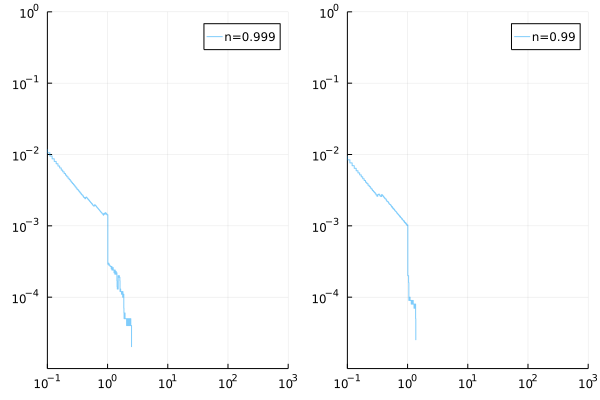

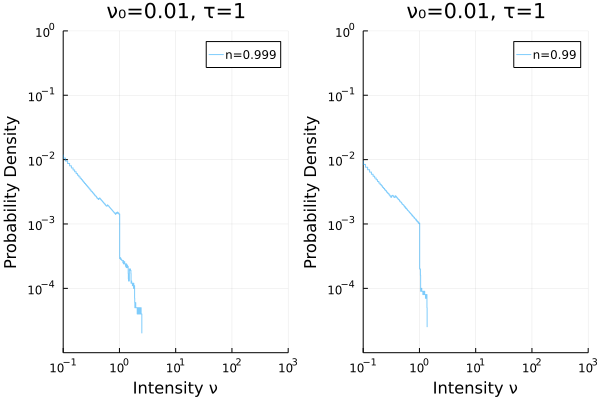

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

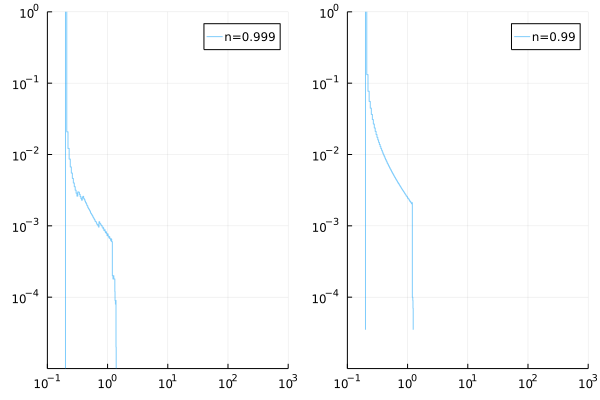

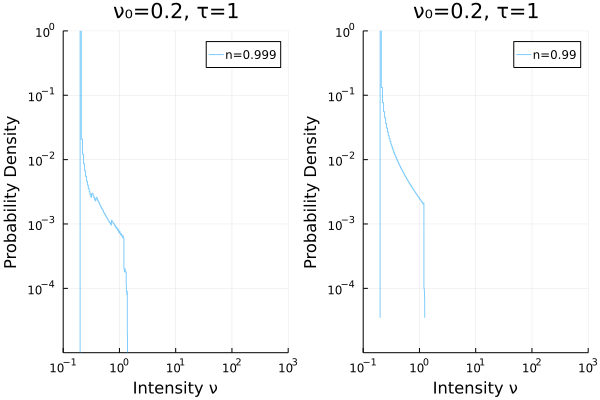

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


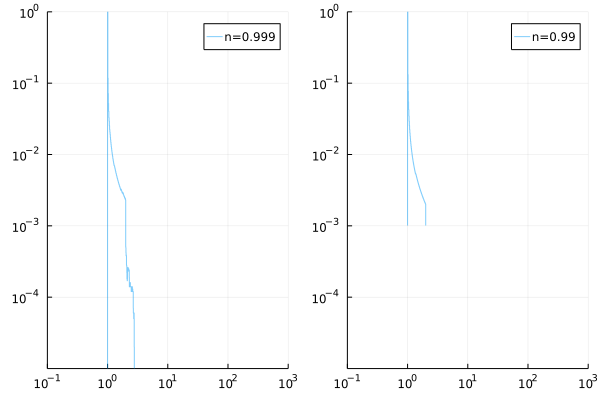

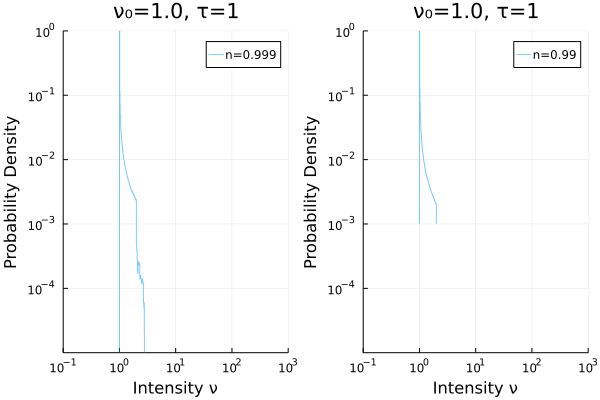

In [2]:
using Plots
using ProgressMeter
using Distributions

# パラメータ
τ = 1.0
dt = 0.001
T = 10000
ν_0_values = [0.01, 0.2, 1.0]
n_values = [0.999, 0.99]

# 強度ν(t)の計算関数
function calculate_ν(t, events, n, ν_0, τ)
    ν_t = ν_0
    for event in events
        if event <= t
            ν_t += (1/τ) * exp(-(t - event) / τ)
        else
            break # tより大きいイベントに達したらループを抜ける
        end
    end
    return ν_t
end

# P_{ss}(ν)の式
P_ss(ν, ν_0, τ, n) = ν^(-1 + 2*ν_0*τ) * exp(-2*τ*(1-n)*ν)

# 強度ν(t)の計算をベクトル化するのは難しいが、事前計算可能な部分を最適化する
# ここでは具体的な改善案を示すのは難しいが、原則として事前計算を考慮する

# シミュレーションとグラフのプロット関数の改善案
function simulate_and_plot(ν_0, τ, T, dt, n_values)
    plots = []
    for n in n_values
        events = Float64[]
        t = 0.0
        while t <= T
            ν_t = calculate_ν(t, events, n, ν_0, τ)
            # イベントが発生する確率に基づいた時間間隔の推定
            rate = ν_t * dt
            if rate > 0
                # 指数分布を使用して次のイベントまでの時間を推定
                interval = rand(Exponential(1 / rate))
                next_t = t + interval
                if next_t <= T
                    push!(events, next_t)
                    t = next_t
                    continue
                end
            end
            t += dt
        end

        # intensitiesの計算にベクトル化を適用
        ts = 0:dt:T
        intensities = calculate_ν.(ts, Ref(events), n, ν_0, τ)# Refはeventsをスカラーとして扱うために使用

        # データの事前集計 (例: intensitiesのビンごとの平均値の計算)
        # 集計方法はデータと目的に応じて適宜変更してください
        bins = 0:0.1:maximum(intensities) # ビンの範囲とサイズを定義
        binned_intensities = [mean(intensities[(intensities .>= bin) .& (intensities .< bin+0.1)]) for bin in bins]

        # プロット設定の再利用
        plot_settings = (xscale=:log10, yscale=:log10, xticks=10.0.^(-1:3), yticks=10.0.^(-5:0), xlims=(10^-1, 10^3), ylims=(10^-5, 10^0), alpha=0.5, label="n=$n")

        # プロットの生成
        p = histogram(intensities, normed=true, label="n=$n", xscale=:log10, yscale=:log10, xticks=10.0 .^ (-1:3), yticks=10.0 .^ (-5:0), xlims=(10^-1, 10^3), ylims=(10^-5, 10^0), alpha=0.5)
        push!(plots, p)
    end
    final_plot = plot(plots..., legend=:topright)
    display(final_plot)

end


# 各ν_0の値に対してグラフを生成
progressbar = Progress(length(ν_0_values))
for ν_0 in ν_0_values
    next!(progressbar)
    simulate_and_plot(ν_0, τ, T, dt, n_values)
    title!("ν₀=$ν_0, τ=1")
    xlabel!("Intensity ν")
    ylabel!("Probability Density")
    display(plot!())
end
